# LSTM with k-fold and default split 80/20 on MNIST dataset

In [1]:
import os
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

# Load the MNIST dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Merge Train and Test Instances to Create Merge Dataset

In [3]:
X_data = []
y_data = []
for i in range(10):
    class_indices = np.where(y_train == i)[0][:]
    X_data.extend(X_train[class_indices])
    y_data.extend(y_train[class_indices])

In [4]:
X_data = np.array(X_data)
y_data = np.array(y_data)


In [5]:
print(X_data.shape)

(60000, 28, 28)


# Reshape and preprocess the data


In [6]:
input_dim = X_data.shape[1] * X_data.shape[2]
X_data = X_data.reshape((-1, 1, input_dim))
X_data = X_data.astype('float32') / 255.0  # Normalize pixel values

In [7]:
num_classes = 10
k = 5  # Number of folds
accuracies = []
f1_scores = []
sensitivities = []
specificities = []
precisions = []
recalls = []
TPRs = []
FPRs = []

total_cm = np.zeros((num_classes, num_classes))


# LSTM with k-fold cross-validation where k =10

In [ ]:
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_data):
    X_train, X_test = X_data[train_index], X_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    # Build and train the LSTM model
    model = Sequential()
    memory_cell = 128
    model.add(LSTM(memory_cell, input_shape=(1, input_dim), activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=3, batch_size=8, verbose=2)

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_test, y_pred_classes)
    
    TP = np.diag(cm)
    FN = np.sum(cm, axis=1) - TP
    FP = np.sum(cm, axis=0) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    
    total_cm += cm

    
    try:
        fpr, tpr, _ = roc_curve(y_test, y_pred_classes, pos_label=i)
        auc_value = auc(fpr, tpr)
        TPRs.append(tpr)
        FPRs.append(fpr)
    except ValueError:
        continue 
   
    accuracies.append(accuracy)
    f1_scores.append(f1)
    recalls.append(recall)
    precisions.append(precision)
    sensitivities.append(np.mean(sensitivity))
    specificities.append(np.mean(specificity))
    TPRs.append(tpr)
    FPRs.append(fpr)

Epoch 1/3
6000/6000 - 4466s - loss: 0.2196 - accuracy: 0.9357 - 4466s/epoch - 744ms/step
Epoch 2/3
6000/6000 - 108s - loss: 0.0870 - accuracy: 0.9733 - 108s/epoch - 18ms/step
Epoch 3/3
6000/6000 - 106s - loss: 0.0548 - accuracy: 0.9830 - 106s/epoch - 18ms/step
375/375 [==============================] - 3s 6ms/step
Epoch 1/3
6000/6000 - 1198s - loss: 0.2245 - accuracy: 0.9341 - 1198s/epoch - 200ms/step
Epoch 2/3
6000/6000 - 1654s - loss: 0.0945 - accuracy: 0.9713 - 1654s/epoch - 276ms/step
Epoch 3/3
6000/6000 - 55s - loss: 0.0604 - accuracy: 0.9819 - 55s/epoch - 9ms/step
375/375 [==============================] - 1s 3ms/step
Epoch 1/3
6000/6000 - 35s - loss: 0.2246 - accuracy: 0.9334 - 35s/epoch - 6ms/step
Epoch 2/3
6000/6000 - 33s - loss: 0.0923 - accuracy: 0.9730 - 33s/epoch - 5ms/step
Epoch 3/3
6000/6000 - 36s - loss: 0.0612 - accuracy: 0.9811 - 36s/epoch - 6ms/step
375/375 [==============================] - 1s 3ms/step
Epoch 1/3
6000/6000 - 33s - loss: 0.2222 - accuracy: 0.9354 - 33

In [9]:
print("Mean Accuracy: {:.2f}% (+/- {:.2f}%)".format(np.mean(accuracies) * 100, np.std(accuracies) * 100))
print("Mean F1 Score: {:.2f}".format(np.mean(f1_scores)))
print("Mean Sensitivity: {:.2f}".format(np.mean(sensitivities)))
print("Mean Specificity: {:.2f}".format(np.mean(specificities)))
print("Mean Precision: {:.2f}".format(np.mean(precisions)))
print("Mean Recall: {:.2f}".format(np.mean(recalls)))


Mean Accuracy: 97.27% (+/- 0.32%)
Mean F1 Score: 0.97
Mean Sensitivity: 0.97
Mean Specificity: 1.00
Mean Precision: 0.97
Mean Recall: 0.97


# Plot Precision-Recall curve


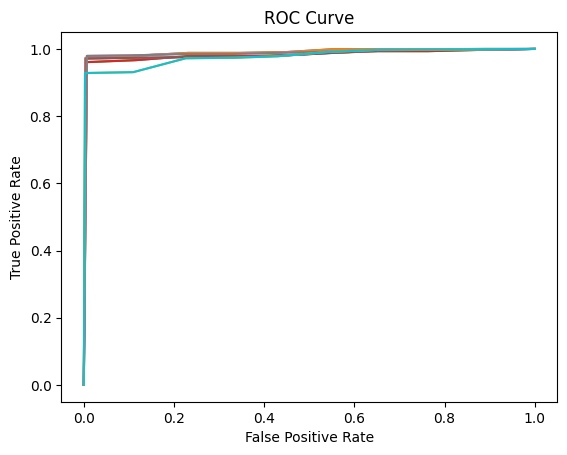

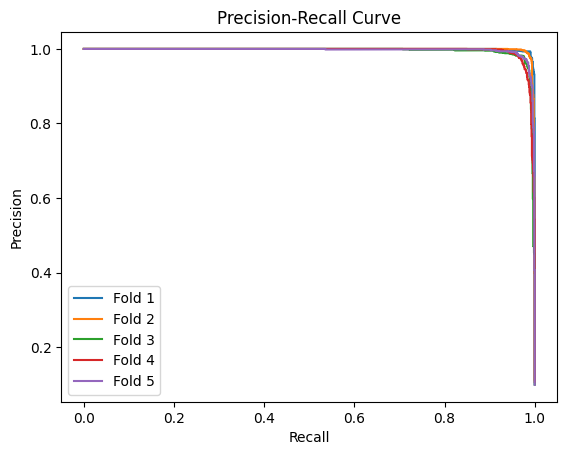

In [10]:
plt.figure()
for fpr, tpr in zip(FPRs, TPRs):
    plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

plt.figure()
for i in range(k):
    precision, recall, _ = precision_recall_curve(y_test, y_pred[:, i], pos_label=i)
    plt.plot(recall, precision, label=f'Fold {i + 1}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot Confusion Matrix for each fold


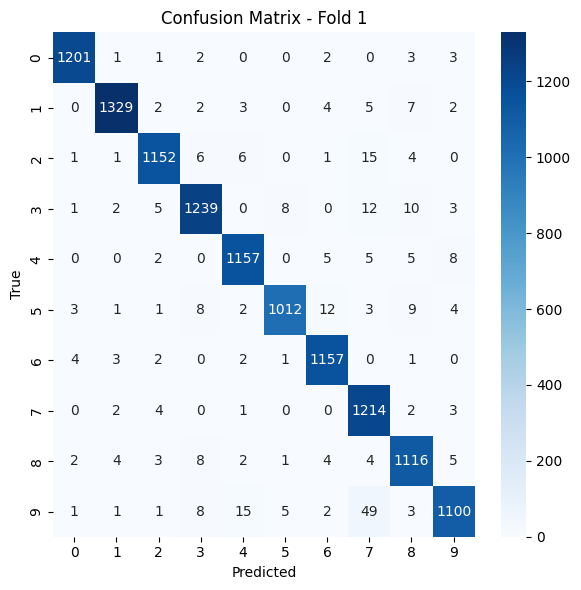

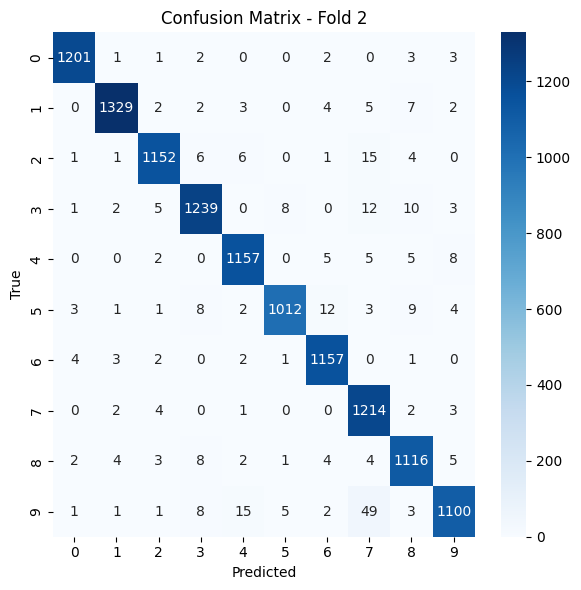

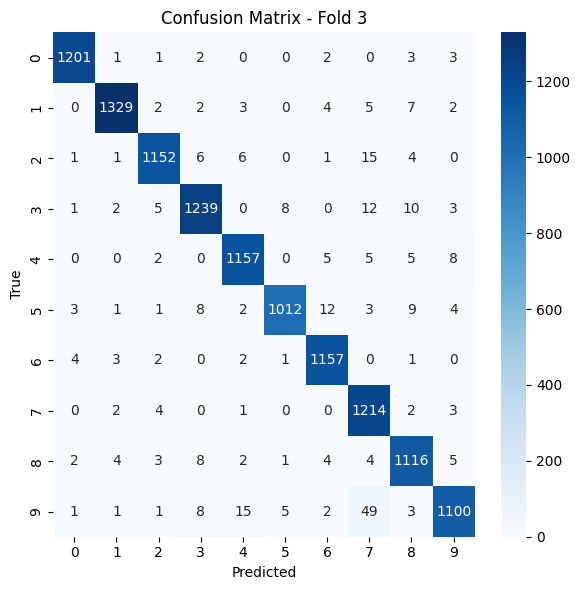

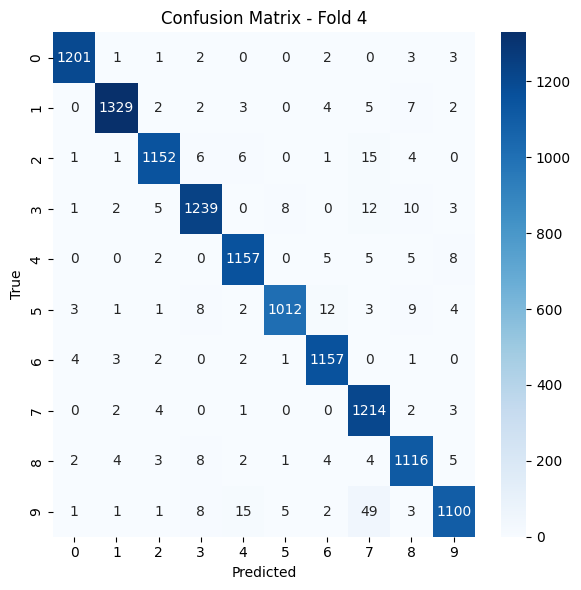

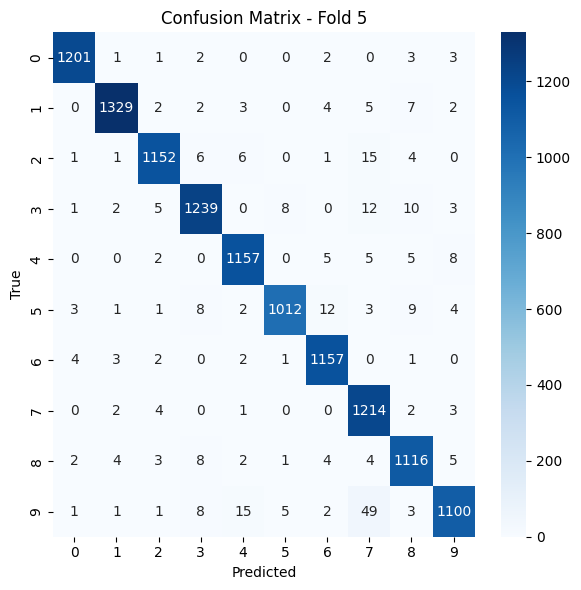

In [13]:
import seaborn as sns

for i in range(k):
    plt.figure(figsize=(6, 6)) 
    cm = confusion_matrix(y_test, y_pred_classes)  
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Fold {i + 1}')
    plt.tight_layout()
    plt.show() 


# Plot Confusion Matrix


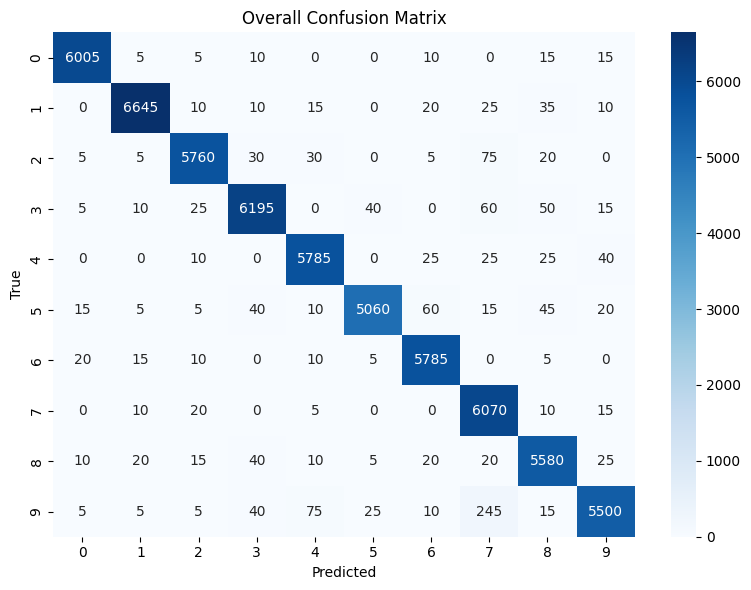

In [12]:
import seaborn as sns
plt.figure(figsize=(8, 6))

overall_cm = np.zeros((10, 10), dtype=int)
for i in range(k):
    overall_cm += confusion_matrix(y_test, y_pred_classes)

sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Overall Confusion Matrix')
plt.tight_layout()
plt.show()


# LSTM on Default dataset(80/20 split)

In [14]:
# Load the MNIST dataset 
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [15]:
input_dim = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((-1, 1, input_dim))
X_test = X_test.reshape((-1, 1, input_dim))
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Define the LSTM model

In [16]:
num_classes = 10
memory_cell = 128

model = Sequential()
model.add(LSTM(memory_cell, input_shape=(1, input_dim), activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [18]:
model.fit(X_train, y_train, epochs=5, batch_size=8, verbose=2)

Epoch 1/5
7500/7500 - 149s - loss: 0.0761 - accuracy: 0.9764 - 149s/epoch - 20ms/step
Epoch 2/5
7500/7500 - 142s - loss: 0.0514 - accuracy: 0.9845 - 142s/epoch - 19ms/step
Epoch 3/5
7500/7500 - 149s - loss: 0.0389 - accuracy: 0.9879 - 149s/epoch - 20ms/step
Epoch 4/5
7500/7500 - 147s - loss: 0.0315 - accuracy: 0.9897 - 147s/epoch - 20ms/step
Epoch 5/5
7500/7500 - 147s - loss: 0.0272 - accuracy: 0.9916 - 147s/epoch - 20ms/step


# Evaluate the model


In [21]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
cm = confusion_matrix(y_test, y_pred_classes)

313/313 [==============================] - 1s 4ms/step


In [22]:
TP = np.diag(cm)
FN = np.sum(cm, axis=1) - TP
FP = np.sum(cm, axis=0) - TP
TN = np.sum(cm) - (TP + FN + FP)

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

In [24]:
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1 Score: {:.2f}".format(f1))
print("Sensitivity: {:.2f}".format(np.mean(sensitivity)))
print("Specificity: {:.2f}".format(np.mean(specificity)))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))


Accuracy: 97.33%
F1 Score: 0.97
Sensitivity: 0.97
Specificity: 1.00
Precision: 0.97
Recall: 0.97


# Plot the confusion matrix


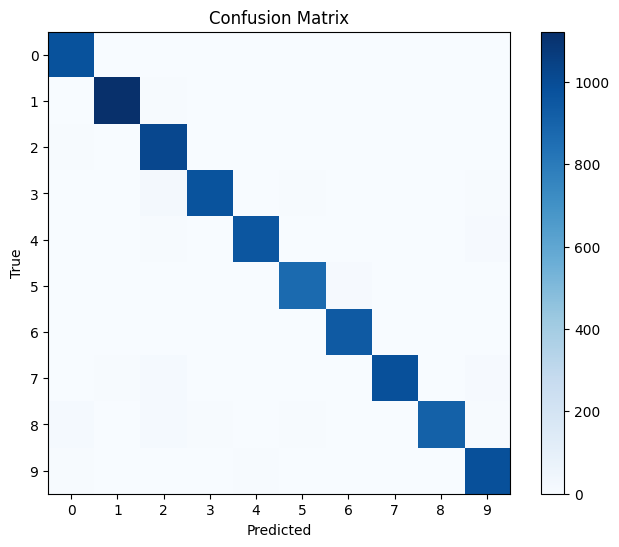

In [25]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(10), np.arange(10))
plt.yticks(np.arange(10), np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot ROC curve of each class

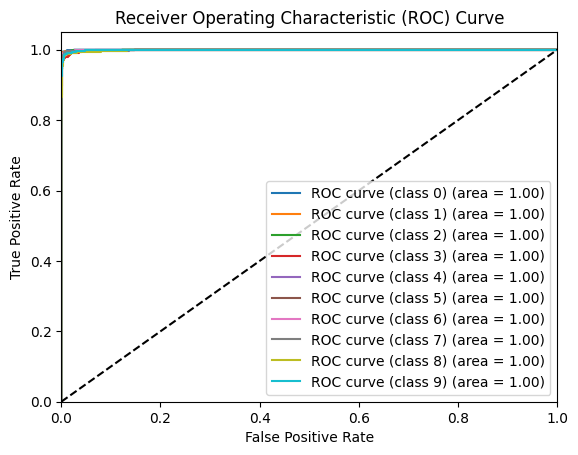

In [32]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})') 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute PR curve for each class

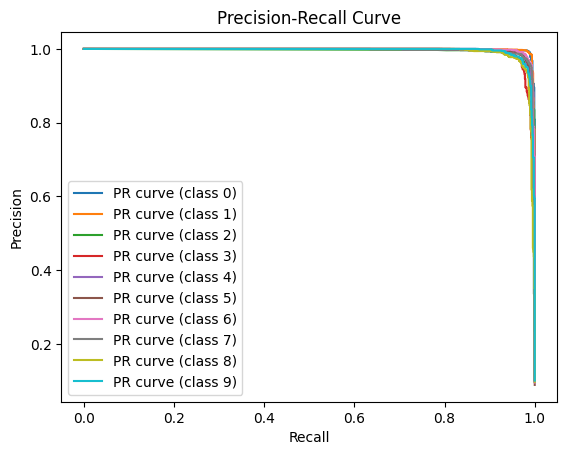

In [33]:
precision = dict()
recall = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_pred[:, i])

plt.figure()
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'PR curve (class {i})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()